# Validation with external data set

Here we will validate the major findings in the data from [Bar et. al.](https://doi.org/10.1038/s41586-020-2896-2). They estimated explained variances using RandomForest models in a validatin cohort using the same metabolomics provider as our study.

In [1]:
import pandas as pd

joint_r_sq = pd.read_excel("data/41586_2020_2896_MOESM3_ESM.xlsx", "Supplementary Table 6")
meta = pd.read_excel("data/41586_2020_2896_MOESM3_ESM.xlsx", "Supplementary Table 1")

joint_r_sq["CHEMICAL_ID"] = joint_r_sq["Grouped Metabolites"].astype(str).str.split("+").str[0]
meta.CHEMICAL_ID = meta.CHEMICAL_ID.astype(str)
joint_r_sq = pd.merge(joint_r_sq, meta, on="CHEMICAL_ID")
joint_r_sq = joint_r_sq[(joint_r_sq["Genetics p-value"] < 0.05) | (joint_r_sq["Microbiome p-value"] < 0.05)]
joint_r_sq[["Grouped Metabolites", "CHEMICAL_ID", "BIOCHEMICAL"]]
joint_r_sq["metabolite"] = "metabolite_" + joint_r_sq.CHEMICAL_ID

Now we will classify the groups as before.

In [2]:
joint_r_sq["micro_r2"] = joint_r_sq["Microbiome R2"].apply(lambda x: x if x>0 else 0)
joint_r_sq["geno_r2"] = joint_r_sq["Genetics R2"].apply(lambda x: x if x>0 else 0)
joint_r_sq["total"] = joint_r_sq["micro_r2"] + joint_r_sq["geno_r2"]

joint_r_sq["group"] = "hybrid"
joint_r_sq.loc[(joint_r_sq["micro_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "genetics"
joint_r_sq.loc[(joint_r_sq["geno_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "microbiome"
joint_r_sq.sort_values(by="total", ascending=True, inplace=True)
joint_r_sq["BIOCHEMICAL"] = pd.Categorical(joint_r_sq.BIOCHEMICAL, joint_r_sq.BIOCHEMICAL.unique())
joint_r_sq.sort_values(by="total", ascending=False, inplace=True)
joint_r_sq.to_csv("joint_r_squared.csv", index=False)
joint_r_sq = joint_r_sq[~joint_r_sq.BIOCHEMICAL.str.startswith("X -")]

top = []
for g in ["genetics", "microbiome", "hybrid"]:
    top.extend(joint_r_sq[joint_r_sq.group == g].iloc[0:10]["Grouped Metabolites"])

long = joint_r_sq[["Grouped Metabolites", "BIOCHEMICAL", "group", "micro_r2", "geno_r2"]].melt(id_vars=["Grouped Metabolites", "BIOCHEMICAL", "group"], value_name="r2", var_name = "type")

In [3]:
train_r_sq = pd.read_csv("data/train_joint_r_sq.csv").merge(joint_r_sq, left_on="BIOCHEMICAL_NAME", right_on="BIOCHEMICAL")
valid_r_sq = pd.read_csv("data/valid_joint_r_sq.csv").merge(joint_r_sq, left_on="BIOCHEMICAL_NAME", right_on="BIOCHEMICAL")
train_r_sq["cohort"] = "training"
valid_r_sq["cohort"] = "validation"
comparison = pd.concat([train_r_sq, valid_r_sq])

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 3 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/external_r2_microbiome.pdf


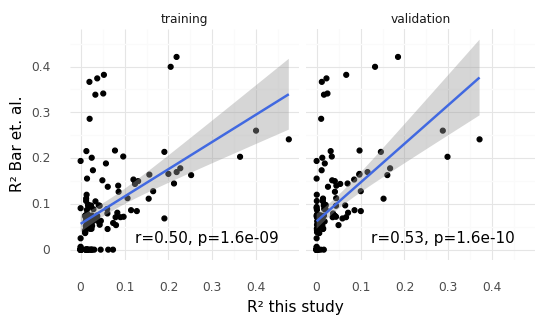

<ggplot: (8747032541790)>

In [8]:
from plotnine import *
from scipy.stats import pearsonr

theme_set(theme_minimal())

cor = comparison.groupby("cohort").apply(lambda df: pd.Series(pearsonr(df.micro_r2_x, df.micro_r2_y), index=["r", "p"])).reset_index()
cor["label"] = [f"r={row.r:.2f}, p={row.p:.2g}" for _, row in cor.iterrows()]

pl = (
    ggplot(comparison)
    + aes(x="micro_r2_x", y="micro_r2_y")
    + geom_point()
    #+ geom_point(data=comparison.dropna(subset=["SUB_PATHWAY_x"])[comparison.dropna(subset=["SUB_PATHWAY_x"]).SUB_PATHWAY_x.str.startswith("Xanthine")], color="orange")
    + geom_text(cor, aes(label="label"), x=0.45, y=0.025, ha="right")
    + stat_smooth(method="lm", color="royalblue")
    + facet_wrap("~ cohort")
    + labs(x="R² this study", y="R² Bar et. al.")
    + theme(figure_size=(6, 3))
)
pl.save("figures/external_r2_microbiome.pdf", width=6, height=3)
pl

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 3 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/external_r2_genetics.pdf


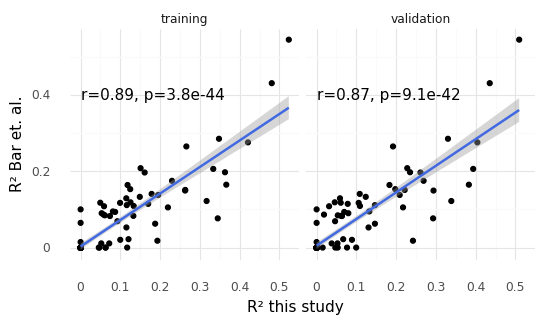

<ggplot: (8747034409719)>

In [5]:
from plotnine import *
from scipy.stats import pearsonr

theme_set(theme_minimal())

cor = comparison.groupby("cohort").apply(lambda df: pd.Series(pearsonr(df.geno_r2_x, df.geno_r2_y), index=["r", "p"])).reset_index()
cor["label"] = [f"r={row.r:.2f}, p={row.p:.2g}" for _, row in cor.iterrows()]

pl = (
    ggplot(comparison)
    + aes(x="geno_r2_x", y="geno_r2_y")
    + geom_point()
    + geom_text(cor, aes(label="label"), x=0, y=0.4, ha="left")
    + stat_smooth(method="lm", color="royalblue")
    + facet_wrap("~ cohort")
    + labs(x="R² this study", y="R² Bar et. al.")
    + theme(figure_size=(6, 3))
)
pl.save("figures/external_r2_genetics.pdf", width=6, height=3)
pl

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/bar_r2.pdf


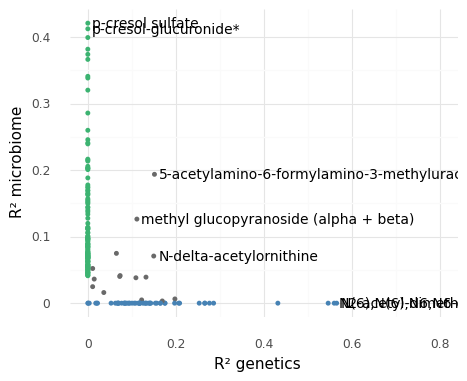

<ggplot: (8747034347876)>

In [6]:
from plotnine import *
from mizani.formatters import percent_format

pl = (
    ggplot(joint_r_sq, aes(x="geno_r2", y="micro_r2", color="group"))
    + geom_point(size=2, stroke=0)
    + geom_text(
        aes(label="BIOCHEMICAL"), 
        data=joint_r_sq[
            ((joint_r_sq.total > 0.22) & (joint_r_sq.group == "hybrid")) 
            | (joint_r_sq.micro_r2 > 0.4) 
            | (joint_r_sq.geno_r2 > 0.55)], 
        ha="left", nudge_x=0.01, size=10, color="black")
    + theme_minimal()
    + theme(figure_size=(5,4))
    + xlim(0, 0.8)
    + scale_color_manual(values={"genetics": "steelblue", "microbiome": "mediumseagreen", "hybrid": "dimgray"})
    + labs(x="R² genetics", y="R² microbiome") + guides(color=None)
)
pl.save("figures/bar_r2.pdf", width=6, height=4)
pl

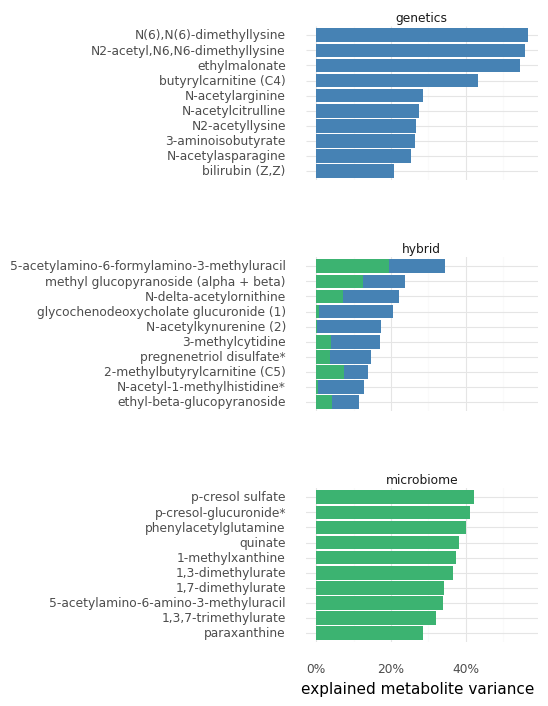

<ggplot: (8747034221454)>

In [7]:
pl = (
    ggplot(long[(long.r2 > 0.0) & (long["Grouped Metabolites"].isin(top))].sort_values(by="r2"), aes(y="r2", x="BIOCHEMICAL", fill="type"))
    + geom_bar(stat="identity") 
    + scale_y_continuous(labels=percent_format())
    + coord_flip()
    + facet_wrap("~ group", scales="free_y", ncol=1)
    + labs(y = "explained metabolite variance", x="")
    + scale_fill_manual(values=["steelblue", "mediumseagreen"])
    + guides(fill = None)
    + theme_minimal() 
    + theme(figure_size=(3, 8), subplots_adjust={"hspace": 0.5})
)
#pl.save("figures/external_specific_r2.pdf", width=3, height=6)
pl